# Figure 5 Encoding distribution

In [ ]:
import gc
import os
import pickle
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from maskedvae.utils.utils import load_individual_pickle, save_as_pickle, squared_error
from maskedvae.plotting.plotting import (cm2inch, make_col_dict_monkey, get_title_dict, plot_position_traces_ax,
                                        plot_spikes_mean_and_samples_rates_ax, boxplot_masked_naive_ax,
                                        plot_bits_per_spike_per_neuron_ax, plot_multiarr_hist_ax,
                                        plot_sample_cumulative_prob_ratio_neuron_ax)


fontsize=10
plt.rcParams.update({'font.size': fontsize})
plt.rcParams.update({'axes.spines.right': False})
plt.rcParams.update({'axes.spines.top': False})
plt.rcParams.update({'xtick.labelsize': fontsize})
plt.rcParams.update({'ytick.labelsize': fontsize})
plt.rcParams.update({'axes.titlesize': fontsize})
plt.rcParams.update({'axes.labelsize': fontsize})
plt.rcParams.update({'legend.fontsize': fontsize})
  
# reload the developing code 
%load_ext autoreload
%autoreload 2


temp_dir = "../../runs/monkey/"


maskedloss=True
new_date=True


# now read it in note that these are different from the ones
# in the paper so exact numerical values will be different
with open("./R_runs_xam_poisson_xby_gnll_beta_1.txt", "r") as f:
    run_dirs = f.readlines()
run_dirs = [x.strip() for x in run_dirs] # remove \n


col_dict = make_col_dict_monkey()
title_dict = get_title_dict()

### set up dictionaries and select runs

In [2]:
dimwise = True # dimwise scaling
cross_loss = False # no cross loss 
beta_val = 1 # vae beta
nll_beta = 0.3 # gnll beta

data_directory_fig_5 = "../../data/monkey/encoding/" 
local_dir = "../../data/monkey/"

# create the dictioniaries make dires if they dont exist
if not os.path.exists(local_dir):
    os.makedirs(local_dir)
if not os.path.exists(local_dir + "figures/"):
    os.makedirs(local_dir + "figures/")
if not os.path.exists(data_directory_fig_5):
    os.makedirs(data_directory_fig_5)
    

# check how many masked and all obs runs there are 
count_masked = 0
count_naive = 0
for run in run_dirs:
    count_masked += 1 if "masked" in run else 0
    count_naive += 1 if "all_obs" in run else 0
print(f"count_masked: {count_masked}, count_naive: {count_naive}")

if count_naive > count_masked:
    run_dirs = run_dirs[: 2 * count_masked]
    
all_obs_run = len(run_dirs) - 1
masked_run = 0
indices_runs = [masked_run, masked_run + 1, all_obs_run - 1, all_obs_run]

count_masked: 16, count_naive: 16


### read in all the files for plotting 

In [3]:
all_calibs = []
all_neuro = []
run_names = []
session_xb_d_gt = []
session_xb_y_gt = []
session_neuro_gt = []
all_mean_decoding = []
model_tags = []

dict_names = [
    "all_calibs",
    "all_neuro",
    "run_names",
    "session_xb_d_gt",
    "session_xb_y_gt",
    "session_neuro_gt",
    "all_mean_decoding",
    "model_tags",
    "squared_errs",
    "summed_squared_errs",
]

load_from_scratch = False
if load_from_scratch:
    for q, run in enumerate(run_dirs): 
        # load calibration dict
        with open(os.path.join(temp_dir, run, "calibration_dict.pkl"), "rb") as f:
            calibration_dict = pickle.load(f)
        with open(os.path.join(temp_dir, run, "samples.pkl"), "rb") as f:
            samples = pickle.load(f)
        with open(os.path.join(temp_dir, run, "session_data_0.pkl"), "rb") as f:
            session_data = pickle.load(f)
        with open(os.path.join(temp_dir, run, "LogL_mean_decoding.pkl"), "rb") as f:
            logL_mean_decoding = pickle.load(f)
        with open(os.path.join(temp_dir, run, "mean_decoding.pkl"), "rb") as f:
            all_mean_decoding.append(pickle.load(f))
        
        # make sure it does not get too big
        if q in indices_runs:
            all_neuro.append(samples["xa_m"])
            session_neuro_gt.append(session_data["xa_m"].detach().cpu().numpy())
            all_calibs.append(calibration_dict)

        else:
            all_neuro.append(0)
            session_neuro_gt.append(0)
            all_calibs.append(0)

        run_names.append(run)
 
        session_xb_d_gt.append(session_data["xb_d"].detach().cpu().numpy())
        session_xb_y_gt.append(session_data["xb_y"].detach().cpu().numpy())

        if "all_obs" in run:
            model_tags.append("naive")
        elif "masked" in run:
            model_tags.append("masked")

        # delete to save memory
        del samples
        del calibration_dict
        del session_data
        gc.collect()

    # postprocess the calibration dicts (too large datafiles to load all at once)
    rebin_tag = "_rebin"  # rebinned by 5 bins or 1 bin for CDF computation
    session_id = t = 0
    squared_errs = {
        q: {
            model_tag: {mask_key: 0 for mask_key in ["all_obs", "xa_m"]}
            for model_tag in model_tags
        }
        for q in range(len(all_calibs))
    }
    summed_squared_errs = {
        q: {
            model_tag: {mask_key: 0 for mask_key in ["all_obs", "xa_m"]}
            for model_tag in model_tags
        }
        for q in range(len(all_calibs))
    }

    for q, run in enumerate(run_dirs):
        # load calibration dict
        with open(os.path.join(temp_dir, run, "calibration_dict.pkl"), "rb") as f:
            calib = pickle.load(f)
        for mask_key in ["all_obs", "xa_m"]:
            n_samples, n_neur, n_calibs = calib["xa_m"][model_tags[q]][mask_key][t][
                "samples" + rebin_tag
            ][0].shape
            squared_errs[q][model_tags[q]][mask_key] = squared_error(
                np.repeat(
                    calib["xa_m"][model_tags[q]][mask_key][t]["gt" + rebin_tag][
                        0
                    ].reshape(1, n_neur, n_calibs),
                    n_samples,
                    axis=0,
                ),
                calib["xa_m"][model_tags[q]][mask_key][t]["samples" + rebin_tag][0],
            )
            summed_squared_errs[q][model_tags[q]][mask_key] = np.mean(
                np.sum(squared_errs[q][model_tags[q]][mask_key], axis=2), axis=0
            )  # mean over 500 samples added over bins

    del calib
    gc.collect()

    # save all data
    for file_name in dict_names:
        data = globals().get(file_name)
        if data is not None:
            save_as_pickle(data, file_name, data_directory_fig_5)
else:
    print("Loading from file...")
    # Loading all files into a dictionary
    loaded_data = {
        file_name: load_individual_pickle(file_name, data_directory_fig_5)
        for file_name in dict_names
    }

    # Dynamically create global variables from the keys of the dictionary
    for key, value in loaded_data.items():
        print(key)
        globals()[key] = value

Loading from file...
all_calibs
all_neuro
run_names
session_xb_d_gt
session_xb_y_gt
session_neuro_gt
all_mean_decoding
model_tags
squared_errs
summed_squared_errs


# Figure 5 Panel F 
### Sampled rates given behavior of both masked and naive VAEs for two neurons 


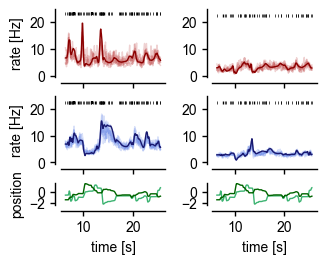

In [4]:

SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 10

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
# make  all fontcolors black
plt.rc("text", color="black")
plt.rc("axes", labelcolor="black")
plt.rc("xtick", color="black")
plt.rc("ytick", color="black")
plt.rc("legend", facecolor="white", edgecolor="white", framealpha=1)

cutoff = 1
axiswidth = 1

figsize_cm = (8, 7)
figsize_inch = cm2inch(figsize_cm)
fig = plt.figure(constrained_layout=True, figsize=figsize_inch)  # , sharex=True)
gs = fig.add_gridspec(8, 2, hspace=0.1, wspace=0.1)

f_ax0_1 = fig.add_subplot(gs[0:3, 0])
f_ax0_2 = fig.add_subplot(gs[6:7, 0])
f_ax0_3 = fig.add_subplot(gs[3:6, 0], sharex=f_ax0_1, sharey=f_ax0_1)
f_ax1_1 = fig.add_subplot(gs[0:3, 1], sharex=f_ax0_1, sharey=f_ax0_1)
f_ax1_2 = fig.add_subplot(gs[6:7, 1])
f_ax1_3 = fig.add_subplot(gs[3:6, 1], sharey=f_ax0_1)

for aa, axs in enumerate([f_ax0_1, f_ax0_2, f_ax0_3, f_ax1_1, f_ax1_2, f_ax1_3]):
    axs.locator_params(tight=True, nbins=3)
    axs.spines["left"].set_position(("outward", 4))
    axs.spines["bottom"].set_position(("outward", 4))
    axs.spines["top"].set_visible(False)
    axs.spines["right"].set_visible(False)
    if aa not in [1, 4]:
        # dont show tick labels
        axs.set_xticklabels([])

q = 0
neuron_id_0 = 0
neuron_id_1 = 183
figure_neuron_ids = [neuron_id_0, neuron_id_1]
thrfps = 0.5  # 0.5#2
fps = 15.625  # 40
sample_step = 10
external_offset = 22
mask_key = "xa_m"
t_min = 100
t_max = 400
time = np.arange(t_min, t_max, 1) / fps

q_n = indices_runs[-1]
q_m = indices_runs[0]

# neuron 1 masked
plot_spikes_mean_and_samples_rates_ax(
    f_ax0_1,
    session_neuro_gt,
    all_mean_decoding,
    all_neuro[q_m],
    q_m,
    t_min=t_min,
    t_max=t_max,
    sample_step=sample_step,
    mask_key=mask_key,
    neuron_id=neuron_id_0,
    model_tags=model_tags,
    time=time,
    fps=fps,
    local_dir=None,
    col_dict=col_dict,
    external_offset=external_offset,
)


# neuron 2 naive
plot_spikes_mean_and_samples_rates_ax(
    f_ax1_1,
    session_neuro_gt,
    all_mean_decoding,
    all_neuro[q_m],
    q_m,
    t_min=t_min,
    t_max=t_max,
    sample_step=sample_step,
    mask_key=mask_key,
    neuron_id=neuron_id_1,
    model_tags=model_tags,
    time=time,
    fps=fps,
    local_dir=None,
    col_dict=col_dict,
    external_offset=external_offset,
)

# plot position traces as the condition
plot_position_traces_ax(
    f_ax0_2,
    session_xb_y_gt,
    q,
    color_x="mediumseagreen",
    color_y="darkgreen",
    t_min=t_min,
    t_max=t_max,
    time=time,
    iflegend=False,
)


# neuron 1 masked
plot_spikes_mean_and_samples_rates_ax(
    f_ax0_3,
    session_neuro_gt,
    all_mean_decoding,
    all_neuro[q_n],
    q_n,
    t_min=t_min,
    t_max=t_max,
    sample_step=sample_step,
    mask_key=mask_key,
    neuron_id=neuron_id_0,
    model_tags=model_tags,
    time=time,
    fps=fps,
    local_dir=None,
    col_dict=col_dict,
    external_offset=external_offset,
)

# neuron 2 naive
plot_spikes_mean_and_samples_rates_ax(
    f_ax1_3,
    session_neuro_gt,
    all_mean_decoding,
    all_neuro[q_n],
    q_n,
    t_min=t_min,
    t_max=t_max,
    sample_step=sample_step,
    mask_key=mask_key,
    neuron_id=neuron_id_1,
    model_tags=model_tags,
    time=time,
    fps=fps,
    local_dir=None,
    col_dict=col_dict,
    external_offset=external_offset,
)

# plot position traces again
plot_position_traces_ax(
    f_ax1_2,
    session_xb_y_gt,
    q,
    color_x="mediumseagreen",
    color_y="darkgreen",
    t_min=t_min,
    t_max=t_max,
    time=time,
    iflegend=False,
    ncols=2,
)


f_ax1_2.set_xlabel("time [s]")
f_ax0_2.set_xlabel("time [s]")
f_ax0_1.set_ylabel(f"rate [Hz]")
f_ax0_3.set_ylabel(f"rate [Hz]")
f_ax0_2.set_ylabel("position")


file_name = f"Fig_5_left_behavior_sample_rates_neuron_{neuron_id_0}_{neuron_id_1}_{mask_key}_{q_m}_{q_n}_shown_samples_{int(50/sample_step)}"

plt.savefig(f"{local_dir}/figures/{file_name}.pdf", bbox_inches="tight")
plt.savefig(f"{local_dir}/figures/{file_name}.png", bbox_inches="tight")

### Compute Poisson NLL 

In [5]:
n_neur = session_neuro_gt[0].shape[1]
rate_ch = np.round(np.mean(session_neuro_gt[q][0, :, t_min:], axis=1) * fps, decimals=2)

# for all mean decoding calculate the poisson log likelihood of the test data
loss = torch.nn.PoissonNLLLoss(log_input=False, reduction="none")
all_logL_mean_prediction = {
    model_tag: {mask_key: [] for mask_key in ["all_obs", "xa_m"]}
    for model_tag in model_tags
}

for q, mean_dec in enumerate(all_mean_decoding):
    for mask_key in ["all_obs", "xa_m"]:
        # get the mean decoding
        mean_decoding = mean_dec["xa_m"][model_tags[q]][mask_key][0][0, :, t_min:]
        # get the ground truth
        gt = session_neuro_gt[0][0, :, t_min:]
        # calculate the log likelihood
        logL = -loss(torch.tensor(mean_decoding), torch.tensor(gt)).numpy()
        all_logL_mean_prediction[model_tags[q]][mask_key].append(logL)

mask_key = "xa_m"
naive_logL = np.array(all_logL_mean_prediction["naive"][mask_key])
masked_logL = np.array(all_logL_mean_prediction["masked"][mask_key])

### Compute correlations and population average RMSE

In [6]:
mse_masked = []
mse_naive = []
t = 0
t_min = 100
t_max = session_neuro_gt[0][0, :, :].shape[1]
mask_key = "xa_m"
for q, mean_dec in enumerate(all_mean_decoding):
    if model_tags[q] == "masked":
        mse_masked.append(
            fps
            * np.sqrt(
                (
                    np.mean(
                        mean_dec["xa_m"][model_tags[q]][mask_key][t][0, :, t_min:t_max],
                        axis=0,
                    )
                    - np.mean(session_neuro_gt[0][0, :, t_min:t_max], axis=0)
                )
                ** 2
            )
        )
    else:
        mse_naive.append(
            fps
            * np.sqrt(
                (
                    np.mean(
                        mean_dec["xa_m"][model_tags[q]][mask_key][t][0, :, t_min:t_max],
                        axis=0,
                    )
                    - np.mean(session_neuro_gt[0][0, :, t_min:t_max], axis=0)
                )
                ** 2
            )
        )
        
mse_masked = np.array(mse_masked)
mse_naive = np.array(mse_naive)

# Figure 5 Panel B, C, D, E & G
### Plot the overal distribution of spikes (B), population avg. (C), log-likelihood (D&E) and cumulative distribution functions (G)

4.96 Hz
4.96 Hz
2.69 Hz
2.69 Hz


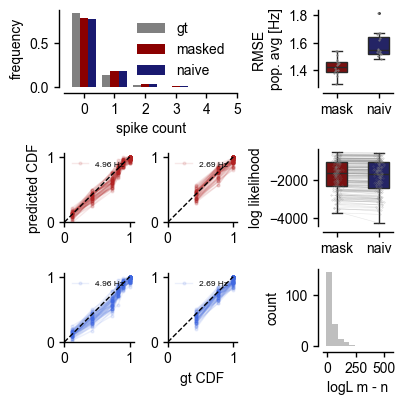

In [7]:
from itertools import product
import seaborn as sns

SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 10

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

# set axis color to black and x,y label color and legend color to black
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.labelcolor"] = "black"
plt.rcParams["xtick.color"] = "black"
plt.rcParams["ytick.color"] = "black"
plt.rcParams["legend.edgecolor"] = "black"
# all text color to black
plt.rcParams["text.color"] = "black"


style_updates = {
    "xtick.color": ".0",
    "ytick.color": ".0",
    "axes.labelcolor": ".0",
    "axes.edgecolor": ".0",
    "text.color": ".0",
    "grid.color": "1.",
    "xtick.bottom": "True",
    "ytick.left": "True",
}

# # Update Seaborn style
sns.set_style(style_updates)

cutoff = 1
axiswidth = 1

figsize_cm = (10, 10)
figsize_inch = cm2inch(figsize_cm)
fig = plt.figure(constrained_layout=True, figsize=figsize_inch)
gs = fig.add_gridspec(3, 6, hspace=0.1, wspace=0.1)

f_ax0_0 = fig.add_subplot(gs[0, 0:4])

f_ax0_1 = fig.add_subplot(gs[0, 4:6])

f_ax1_0 = fig.add_subplot(gs[1, 0:2])

f_ax2_0 = fig.add_subplot(gs[2, 0:2])

f_ax1_1 = fig.add_subplot(gs[1, 2:4])

f_ax2_1 = fig.add_subplot(gs[2, 2:4])

f_ax1_2 = fig.add_subplot(gs[1, 4:6])

f_ax2_2 = fig.add_subplot(gs[2, 4:6])

axes_cdf = [f_ax1_0, f_ax2_0, f_ax1_1, f_ax2_1]
for aa, axs in enumerate(
    [
        f_ax0_0,
        f_ax0_1,
        f_ax0_2,
        f_ax0_3,
        f_ax1_2,
        f_ax2_2,
    ]
):
    axs.locator_params(tight=True, nbins=3)
    axs.spines["left"].set_position(("outward", 4))
    axs.spines["bottom"].set_position(("outward", 4))
    axs.spines["top"].set_visible(False)
    axs.spines["right"].set_visible(False)

f_ax1_0.set_aspect("equal", adjustable="box")
f_ax2_0.set_aspect("equal", adjustable="box")
f_ax1_1.set_aspect("equal", adjustable="box")
f_ax2_1.set_aspect("equal", adjustable="box")

q_n = indices_runs[-1]
q_m = indices_runs[0]

plot_multiarr_hist_ax(
    f_ax0_0,
    session_neuro_gt,
    all_mean_decoding,
    model_tags,
    q_m=q_m,
    q_n=q_n,
    mask_key="xa_m",
    t=0,
    bins=np.arange(6),
    local_dir=None,
    save_name=None,
)
f_ax0_0.set_ylabel("frequency")
f_ax0_0.set_xlabel("spike count")

# plot rmse between predicted mean and true rates
boxplot_masked_naive_ax(
    f_ax0_1, mse_masked, mse_naive, width=0.5, ifmean=True, meanaxis=1
)


axes_cdf = [f_ax1_0, f_ax2_0, f_ax1_1, f_ax2_1]
q_values = [q_m, q_n]  # [0, -1]
neuron_ids = figure_neuron_ids  # [10, 50]
# Generate combinations of q and neuron_id
combinations = product(neuron_ids, q_values)
# Compute the mean firing rate for each neuron during test time (in Hz)
rate_ch = np.round(np.mean(session_neuro_gt[q][0, :, 50:], axis=1) * fps, decimals=2)


# Iterate over axes and combinations
for fax, (neuron_id, q) in zip(axes_cdf, combinations):
    plot_sample_cumulative_prob_ratio_neuron_ax(
        fax,
        all_calibs[q]["xa_m"][model_tags[q]][mask_key][t]["samples_rebin"][0][
            ::sample_step, neuron_id, :
        ],
        all_calibs[q]["xa_m"][model_tags[q]][mask_key][t]["gt_rebin"][0][neuron_id, :],
        label="{0:.2f} Hz".format(rate_ch[neuron_id]) if rate_ch is not None else None,
        color=col_dict[model_tags[q]][mask_key != "all_obs"],
        title_off=True,
        ms=2,
    )
    fax.legend(fontsize=6, frameon=False, loc="upper left")
    fax.spines["top"].set_visible(False)
    fax.spines["right"].set_visible(False)
    fax.set_xlim([0, 1.06])
    fax.set_ylim([0, 1.06])


plot_bits_per_spike_per_neuron_ax(
    f_ax1_2,
    np.sum(naive_logL, axis=2),
    np.sum(masked_logL, axis=2),
    rate_ch=rate_ch,
    n_neur=213,
    ylabel="log likelihood",
)


f_ax2_2.hist(
    np.mean(np.sum(masked_logL, axis=2), axis=0)
    - np.mean(np.sum(naive_logL, axis=2), axis=0),
    bins=np.linspace(-10, 550, 12),
    color="grey",
    alpha=0.5,
)
f_ax2_2.set_xlabel("logL m - n")
f_ax2_2.set_ylabel("count")
# f_ax2_2.set_yscale('log')


f_ax2_1.set_xlabel("gt CDF")
f_ax1_0.set_ylabel("predicted CDF")


savename = f"Fig_5_Version_2_part_2_encoding_{q_m}_{q_n}_CDFs_{figure_neuron_ids[0]}_{figure_neuron_ids[1]}_sum_logL"
plt.savefig(f"{local_dir}/figures/{savename}.pdf", bbox_inches="tight")
plt.savefig(f"{local_dir}/figures/{savename}.png", bbox_inches="tight")

# Figure S5-S8 Supplemenry CDFs for many units

In [ ]:
# Plot all CDFs for all neurons

for q in [0, 1, -2, -1]:
    for mask_key in ["xa_m", "all_obs"]:
    
        fig, axes = plt.subplots(
            7, 7, figsize=cm2inch((35, 35)), sharex=True, sharey=True
        )
        # make subplot with 50 neurons
        for neuron_id in range(213):
            if neuron_id % 49 == 0 and neuron_id != 0:
                # save previous figure
                plt.savefig(
                    f"{local_dir}/figures/cdf_neuron_{neuron_id}_{mask_key}_{q}_{model_tags[q]}.pdf",
                    bbox_inches="tight",
                )
                plt.savefig(
                    f"{local_dir}/figures/cdf_neuron_{neuron_id}_{mask_key}_{q}_{model_tags[q]}.png",
                    bbox_inches="tight",
                )
                fig, axes = plt.subplots(
                    7, 7, figsize=cm2inch((35, 35)), sharex=True, sharey=True
                )
            axes = axes.flatten()
            plot_sample_cumulative_prob_ratio_neuron_ax(
                axes[neuron_id % 49],
                all_calibs[q]["xa_m"][model_tags[q]][mask_key][t]["samples_rebin"][0][
                    ::15, neuron_id, :
                ],
                all_calibs[q]["xa_m"][model_tags[q]][mask_key][t]["gt_rebin"][0][
                    neuron_id, :
                ],
                label=str(neuron_id) + " {0:.2f} Hz".format(rate_ch[neuron_id]),
                color=col_dict[model_tags[q]][mask_key != "all_obs"],
                title_off=True,
            )
            axes[neuron_id % 49].legend(fontsize=8, frameon=False, loc="upper left")

        plt.savefig(
            f"{local_dir}/figures/cdf_neuron_{neuron_id}_{mask_key}_{q}_{model_tags[q]}.pdf",
            bbox_inches="tight",
        )
        plt.savefig(
            f"{local_dir}/figures/cdf_neuron_{neuron_id}_{mask_key}_{q}_{model_tags[q]}.png",
            bbox_inches="tight",
        )
        break
    break